#### CNN 이미지 분류 모델
- 이미지 데이터셋 준비
    - torchvision의 내장 데이터셋 활용 CIFAR10
- 이미지 분류 모델
    - 커스텀 CNN 구현
    

[1] 모듈 로딩 및 데이터 준비 <hr>

In [35]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt


In [4]:
# 데이터 불러오기

# 파이토치의 데이터셋 형태로 로딩 + 텐서화
cifarDS=CIFAR10('../data/', train=True, download=True, 
                transform=ToTensor())

Using downloaded and verified file: ../data/cifar-10-python.tar.gz
Extracting ../data/cifar-10-python.tar.gz to ../data/


In [67]:
cifarDS.data.shape

(50000, 32, 32, 3)

In [10]:
cifarDS.classes, cifarDS.data.shape, len(cifarDS.targets), cifarDS.class_to_idx

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 (50000, 32, 32, 3),
 50000,
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

[2] 데이터 로더<hr>
- 학습시 배치크기만큼 데이터와 라벨/타겟을 로딩

In [13]:
BATCH_SIZE=50
cifarDL= DataLoader(cifarDS)

In [25]:
for f, t in cifarDL:
    print(f.shape, t.shape, f.numpy().squeeze().reshape((32,32,3)).shape)
    print(f.numpy().squeeze().T.shape)
    break
# 채널이 앞에 있네? -> conv2d 위해 shape 자동 변경해줌

torch.Size([1, 3, 32, 32]) torch.Size([1]) (32, 32, 3)
(32, 32, 3)


torch.Size([1, 3, 32, 32]) torch.Size([1]) (32, 32, 3)


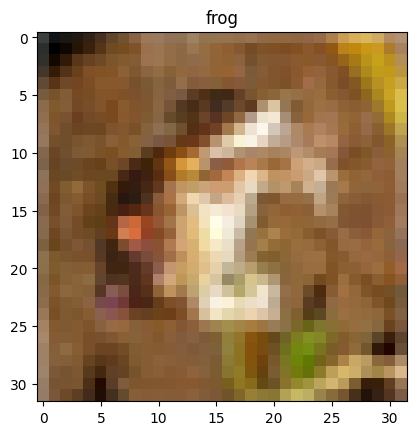

In [30]:
# 이미지 시각화 -> shape 변경이 필요함 (행,열,채널)
for f, t in cifarDL:
    print(f.shape, t.shape, f.numpy().squeeze().reshape((32,32,3)).shape)
    data=f.numpy().squeeze().T
    plt.imshow(data)
    plt.title(cifarDS.classes[t.item()])
    break

[3] 커스텀 모델 설계 및 정의<hr>
- 모델 목적: 이미지 분류 모델
- 학습 방법: 지도학습-> 분류 -> 다중분류 (10개)
- 클래스 이름: imgMCF
- 부모 클래스: nn.Module
- 클래스 구조: 특징추출(CNN) + 학습(FC)

In [53]:
class ImgMCF(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 특징 추출                  채널 수            사용자지정
        self.in_layer= nn.Conv2d(in_channels=3, out_channels=10,
                                 kernel_size=3)
        self.p_layer=nn.MaxPool2d(2, stride=2)
        # 학습
        self.hd_layer=nn.Linear(10*15*15,50)
        self.out_layer=nn.Linear(50,10)

    # 순방향 학습 메서드
    def forward(self, input):
        out=self.in_layer(input)

        out=F.relu(out)

        out=self.p_layer(out)

        out=out.view(out.shape[0], -1)

        out=self.hd_layer(out)
        out=F.relu(out)

        out=self.out_layer(out)
        return out

In [60]:
class ImgMCF2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 특징 추출 
        self.cnn_layer=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10,
                                    kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.cnn_layer2=nn.Sequential(
            nn.Conv2d(10,30,3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        # 학습
        
        self.hd_layer=nn.Linear(30*6*6,50)
        self.out_layer=nn.Linear(50,10)

    # 순방향 학습 메서드
    def forward(self, input):
        self.cnn_layer(input)

        out=out.view(out.shape[0], -1)

        out=self.hd_layer(out)
        out=F.relu(out)

        out=self.out_layer(out)
        return out

In [64]:
m=ImgMCF()        

In [65]:
summary(m, input_size=(1,3,32,32), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
ImgMCF                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 30, 30]           280
│    └─weight                                                      ├─270
│    └─bias                                                        └─10
├─MaxPool2d: 1-2                         [1, 10, 15, 15]           --
├─Linear: 1-3                            [1, 50]                   112,550
│    └─weight                                                      ├─112,500
│    └─bias                                                        └─50
├─Linear: 1-4                            [1, 10]                   510
│    └─weight                                                      ├─500
│    └─bias                                                        └─10
Total params: 113,340
Trainable params: 113,340
Non-trainable params: 0
Total mult-adds (M): 0.37
Input size (MB): 0.01
Forward/b

Layer (type:depth-idx)                   Output Shape              Param #
ImgMCF                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 30, 30]           280
│    └─weight                                                      ├─270
│    └─bias                                                        └─10
├─MaxPool2d: 1-2                         [1, 10, 15, 15]           --
├─Linear: 1-3                            [1, 50]                   112,550
│    └─weight                                                      ├─112,500
│    └─bias                                                        └─50
├─Linear: 1-4                            [1, 10]                   510
│    └─weight                                                      ├─500
│    └─bias                                                        └─10
Total params: 113,340
Trainable params: 113,340
Non-trainable params: 0
Total mult-adds (M): 0.37
Input size (MB): 0.01
Forward/b

In [58]:
# test
for f, t in cifarDL:
    f.shape

    pre=m(f)
    print(pre)
    # pre.argmax(dim=1)
    break

None


In [50]:
for name, param in m.named_parameters():
    print(f'name: {name}, param: {param.shape}')

name: in_layer.weight, param: torch.Size([10, 3, 3, 3])
name: in_layer.bias, param: torch.Size([10])
name: hd_layer.weight, param: torch.Size([50, 2250])
name: hd_layer.bias, param: torch.Size([50])
name: out_layer.weight, param: torch.Size([10, 50])
name: out_layer.bias, param: torch.Size([10])
